In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist

In [2]:
array = np.array([1,2])
array1 = np.array([1,2,3])
array2 = np.array([1,3,3,4])
array1 = array1[:,None]
array2 = array2[:,None,None]
#print(array)
#print(array2)
print(array+array1+array2)

[[[3 4]
  [4 5]
  [5 6]]

 [[5 6]
  [6 7]
  [7 8]]

 [[5 6]
  [6 7]
  [7 8]]

 [[6 7]
  [7 8]
  [8 9]]]


In [3]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [4]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]


2024-06-27 13:59:55.012067: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Computation result: [1. 4. 9.]


In [5]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [6]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [7]:
d = Planck18.distmod(z).value

In [8]:
apr_mag_g = apr_mag_g.astype(np.float64)
apr_mag_g_err = apr_mag_g_err.astype(np.float64)
k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d = d.astype(np.float64)
z = z.astype(np.float64)

In [9]:
print(get_phis(abs_mag_to_L(np.linspace(-40,0,100)),np.linspace(2.3,2.8,100),"shen20").max())

0.4783756734127197


In [10]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import vmap, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from jax import jit
from scipy.integrate import simps, trapz

# Define the functions
def efficiency(x, m0):
    return jnp.where(x < m0, 1, m0 / x)

def normal_pdf(x, mean, sigma):
    # Calculate the PDF of a normal distribution
    return (1.0 / (jnp.sqrt(2 * np.pi) * sigma)) * jnp.exp(-0.5 * ((x - mean) / sigma)**2)
'''
def rejection_sampling(k, d, x, mag_apr, magerr, z, m0, num_samples):
    log_likelihood = []
    for k_val, d_val, mag_apr_val, magerr_val, z_val in zip(k, d, mag_apr, magerr, z):
        M_T_samples = np.random.uniform(-35, -15, num_samples) - x
        valid_M_T_samples = []
        for M_T in M_T_samples:
            Phi = get_phis(abs_mag_to_L(M_T), z_val, "shen20")  # Ensure get_phis and abs_mag_to_L are defined
            if np.random.uniform(0, 1) < 2 * Phi:
                valid_M_T_samples.append(M_T)
        
        valid_M_T_samples = np.array(valid_M_T_samples)
        numerator = jnp.mean(efficiency(mag_apr_val, m0) * normal_pdf(mag_apr_val, valid_M_T_samples + k_val + d_val, magerr_val)) * 20
        
        y = np.linspace(15, 25, 100)
        # Calculate the mean over M_T samples
        integrand_values = jnp.mean(efficiency(y[:, None], m0) * normal_pdf(y[:, None], valid_M_T_samples + k_val + d_val, magerr_val), axis=1)
        denominator = jnp.trapezoid(integrand_values, y) * 20
        
        log_likelihood.append(jnp.log(numerator) - jnp.log(denominator))
        
    return np.array(log_likelihood)
'''

def normal_pdf(x, mean, sigma):
    # Calculate the PDF of a normal distribution
    return (1.0 / (jnp.sqrt(2 * jnp.pi) * sigma)) * jnp.exp(-0.5 * ((x - mean) / sigma)**2)
'''
def integral(k, d, x, mag_apr, magerr, z, m0, num_samples):
    log_likelihood = []
    for k_val, d_val, mag_apr_val, magerr_val, z_val in zip(k, d, mag_apr, magerr, z):
        # Calculate numerator
        M_T = jnp.linspace(-35, -15, 100)
        L = abs_mag_to_L(M_T + x)
        integrand = efficiency(mag_apr_val, m0) * normal_pdf(mag_apr_val, M_T + k_val + d_val, magerr_val) * get_phis(L, z_val,"shen20")
        numerator = jnp.trapezoid(integrand, M_T)
        
        # Calculate denominator
        y_samples = jnp.linspace(15, 25, 100)
        integrand1 = []
        for y in y_samples:
            integrand = efficiency(y, m0) * normal_pdf(y, M_T + k_val + d_val, magerr_val) * get_phis(L, z_val,"shen20")
            integrand1.append(jnp.trapezoid(integrand, M_T))
        integrand1 = jnp.array(integrand1)
        denominator = jnp.trapezoid(integrand1, y_samples)
        
        log_likelihood.append(jnp.log(numerator) - jnp.log(denominator))
    return jnp.array(log_likelihood)
'''
'''
def integral(k, d, x, mag_apr, magerr, z, m0, num_samples):
    # Vectorized operations
    M_T = jnp.linspace(-30, -20, num_samples)
    y_samples = jnp.linspace(15, 25, num_samples)
    
    # Calculate numerator
    L = abs_mag_to_L(M_T[:,None] + x)  # Broadcasting M_T
    #print(efficiency(mag_apr, m0).shape,normal_pdf(mag_apr, M_T[:, None] + k + d, magerr).shape,get_phis(L, z, "shen20").shape)
    integrand = efficiency(mag_apr, m0) * normal_pdf(mag_apr, M_T[:, None] + k + d, magerr) * get_phis(L, z, "shen20")
    #print(integrand.shape)
    #print(M_T.shape)
    numerator = jnp.trapezoid(integrand, M_T, axis=0)
    # Calculate denominator
    def inner_integral(y):
        L_inner = abs_mag_to_L(M_T[:, None] + x)  # Broadcasting M_T
        integrand_inner = efficiency(y, m0) * normal_pdf(y, M_T[:, None] + k + d, magerr) * get_phis(L_inner, z, "shen20")
        return jnp.trapezoid(integrand_inner, y, axis=0)
    #print(M_T[:, None] + k + d)
    integrand1 = inner_integral(y_samples[:,None,None])
    #print(integrand1.shape)
    denominator = jnp.trapezoid(integrand1, M_T, axis=0)
    #print(numerator,denominator)
    print(jnp.log(numerator)-jnp.log(denominator))
   # log_likelihood = jnp.log(numerator) - jnp.log(denominator)
    log_likelihood = jnp.log(numerator/denominator)
    return log_likelihood
    '''
def integral(k, d, x, mag_apr, magerr, z, m0, num_samples):
    # Vectorized operations
    M_T = jnp.linspace(-30, -20, num_samples)
    y_samples = jnp.linspace(15, 25, num_samples)
    
    # Calculate numerator
    L = abs_mag_to_L(M_T[:, None] + x)  # Broadcasting M_T
    integrand = efficiency(mag_apr, m0) * normal_pdf(mag_apr, M_T[:, None] + k + d, magerr) * get_phis(L, z, "shen20")
    numerator = jnp.trapezoid(integrand, M_T, axis=0)
    
    # Calculate denominator
    def inner_integral(y):
        L_inner = abs_mag_to_L(M_T[:, None] + x)  # Broadcasting M_T
        integrand_inner = efficiency(y, m0) * normal_pdf(y, M_T[:, None] + k + d, magerr) * get_phis(L_inner, z, "shen20")
        return jnp.trapezoid(integrand_inner, M_T, axis=0)
    
    integrand1 = inner_integral(y_samples[:, None, None])
    denominator = jnp.trapezoid(integrand1, y_samples, axis=0)  # Integrate over y_samples
    
    # Adding a small constant to avoid division by zero or log of zero
    eps = 1e-40
    numerator = jnp.maximum(numerator, eps)
    denominator = jnp.maximum(denominator, eps)
    
    log_likelihood = jnp.log(numerator / denominator)
    
    return log_likelihood
# Define the model using NumPyro
def model(k, d, mag_apr, magerr, z):
    x = numpyro.sample('x', dist.Uniform(-5, 5))
    m0 = numpyro.sample('m0', dist.Uniform(0, 30))  # Adjusted prior range
    
    log_L = jnp.sum(integral(k, d, x, mag_apr, magerr, z, m0, num_samples=100))
    # Sum of log-likelihoods    
    # Use numpyro.factor to add log_L_sum to the log probability of the model
    numpyro.factor('log_L', log_L)

In [11]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 3000, 7000
i_start = 10000
i_end = i_start+10000
# Initialize batch parameters for the entire dataset

init_params = {
    'x': 0 * jnp.ones((1,)),  
    'm0': 25 * jnp.ones((1,)),  
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over the entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, k_rr[i_start:i_end], d[i_start:i_end], apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z[i_start:i_end])
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 10000/10000 [03:41<00:00, 45.18it/s, 3 steps of size 6.93e-01. acc. prob=0.91]


{'m0': Array([19.42101047, 19.78135527, 19.47932574, ..., 19.58689386,
       19.36030203, 19.35199487], dtype=float64), 'x': Array([ 1.17352269e-01,  1.91094296e-01, -8.09384557e-05, ...,
        1.53313701e-01,  4.95392018e-02,  5.44214650e-02], dtype=float64)}


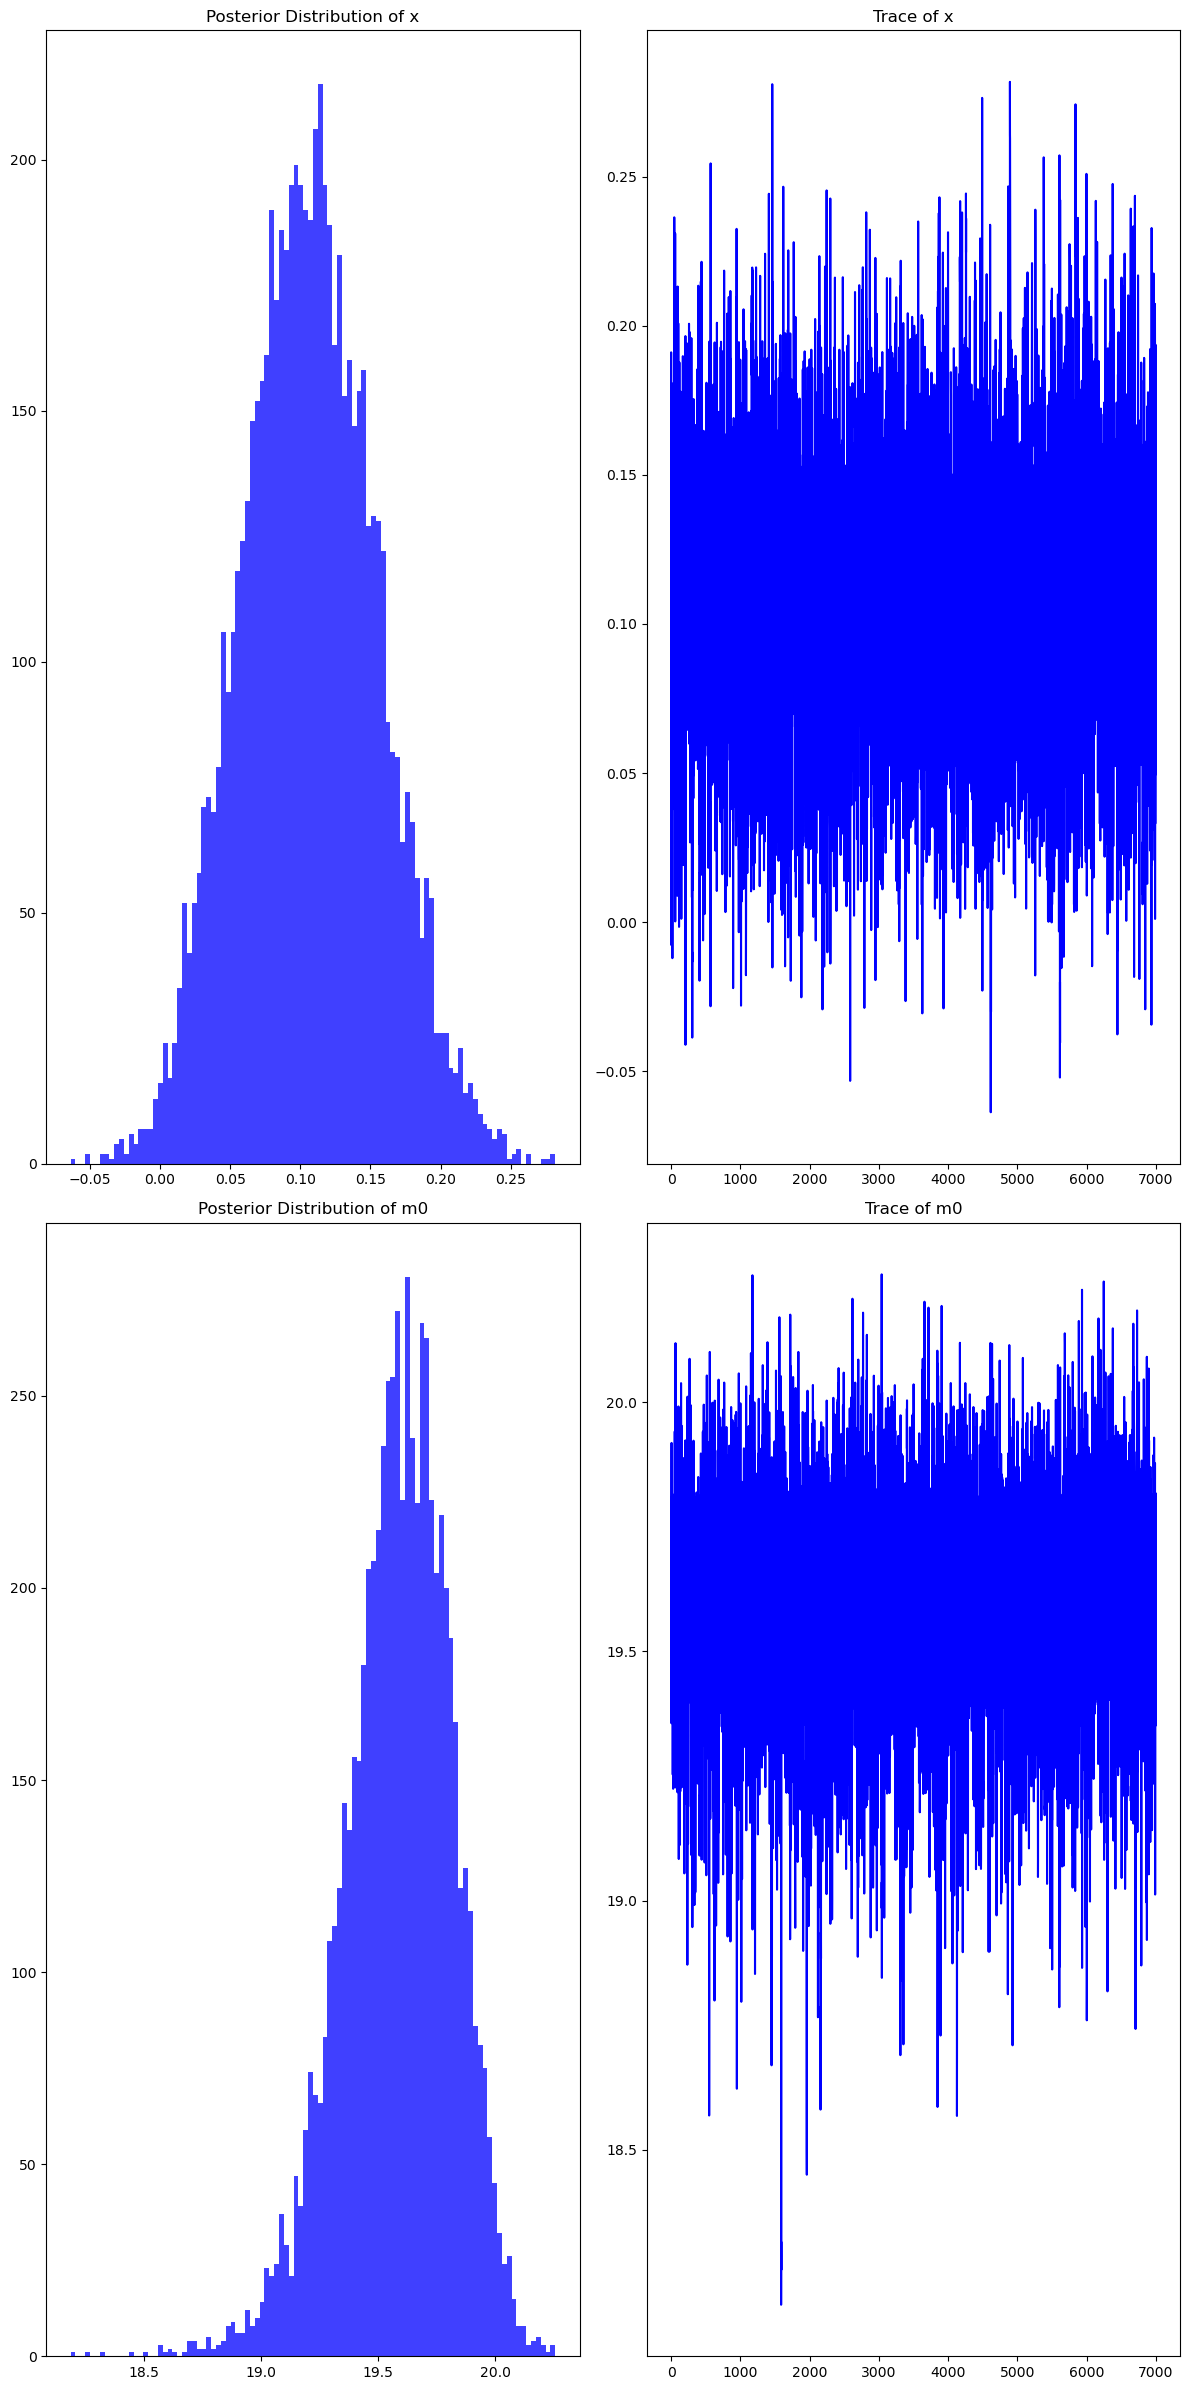

In [12]:
# Extract the chains and parameters
x = samples['x']
m0 = samples['m0']
# Creating a figure to hold the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 24))  # 7 parameters, each with a histogram and trace plot

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

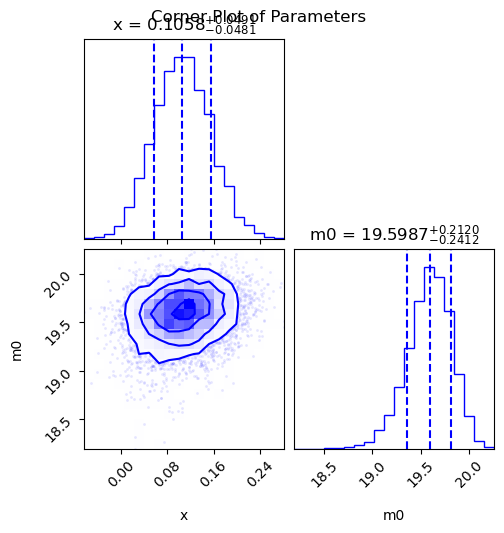

In [13]:
import corner
# Extract samples for plotting
#samples = np.vstack((x, m0)).T
samples = np.vstack((x,m0)).T
# Create a corner plot
fig = corner.corner(samples, labels=['x', 'm0'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()